## **Projeto Típico de Data Science**

Na aula de hoje, vamos desenvolver juntos um projeto de Data Science, explorando e modelando o conjunto de dados relacionado ao tipo de medicamento utilizado para tratar determinadas condições de saúde.



In [27]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split

# ignorar warnings
warnings.filterwarnings('ignore')

In [4]:
# montando drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [6]:
# definir caminho para os dados
FILE_PATH = '/content/drive/MyDrive/Bootcamp_DataScience/Algoritmos de Inteligência Artificial para Classificação/datasets'
FILE_NAME = 'drug200.csv'

In [7]:
# carregar os dados
data = pd.read_csv(os.path.join(FILE_PATH, FILE_NAME))
data.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


In [8]:
# modificar os nomes das colunas
data.columns = data.columns.str.lower()
data.head()

,age,sex,bp,cholesterol,na_to_k,drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


### **Análise Exploratória dos Dados**

In [9]:
# tipos dos dados
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          200 non-null    int64  
 1   sex          200 non-null    object 
 2   bp           200 non-null    object 
 3   cholesterol  200 non-null    object 
 4   na_to_k      200 non-null    float64
 5   drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


In [12]:
# verificando dados nulos - forma tabular
data.isna().sum()

age            0
sex            0
bp             0
cholesterol    0
na_to_k        0
drug           0
dtype: int64

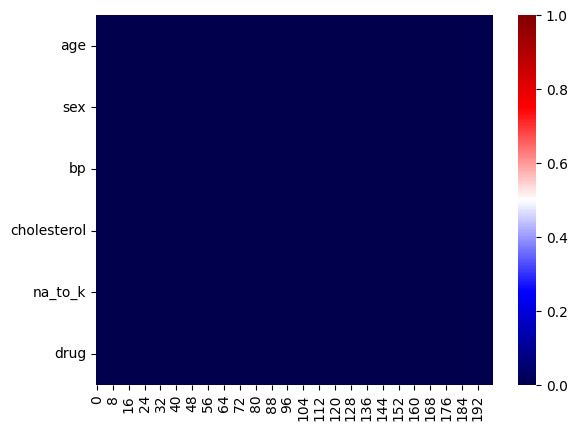

In [13]:
# verificar dados nulos - forma gráfica
sns.heatmap(data.isna().T, vmin=0, vmax=1, cmap='seismic')
plt.show()

In [14]:
# análise descritiva - estatísticas básicas
data.describe()

,age,na_to_k
count,200.000000,200.000000
mean,44.315000,16.084485
std,16.544315,7.223956
min,15.000000,6.269000
25%,31.000000,10.445500
50%,45.000000,13.936500
75%,58.000000,19.380000
max,74.000000,38.247000


- pessoas mais novas têm razão Na/K maior?

In [15]:
# análise descritiva - variáveis categóricas
data['bp'].value_counts(normalize=True)

HIGH      0.385
LOW       0.320
NORMAL    0.295
Name: bp, dtype: float64

In [16]:
# análise descritiva - variáveis categóricas
data['sex'].value_counts(normalize=True)

M    0.52
F    0.48
Name: sex, dtype: float64

In [17]:
# análise descritiva - variáveis categóricas
data['cholesterol'].value_counts(normalize=True)

HIGH      0.515
NORMAL    0.485
Name: cholesterol, dtype: float64

In [18]:
# análise descritiva - variáveis categóricas
data['drug'].value_counts(normalize=True)

DrugY    0.455
drugX    0.270
drugA    0.115
drugC    0.080
drugB    0.080
Name: drug, dtype: float64

- nosso objetivo, nesse trabalho, será criar um classificador one-vs-all para identificar aqueles que tomam o remédio Y

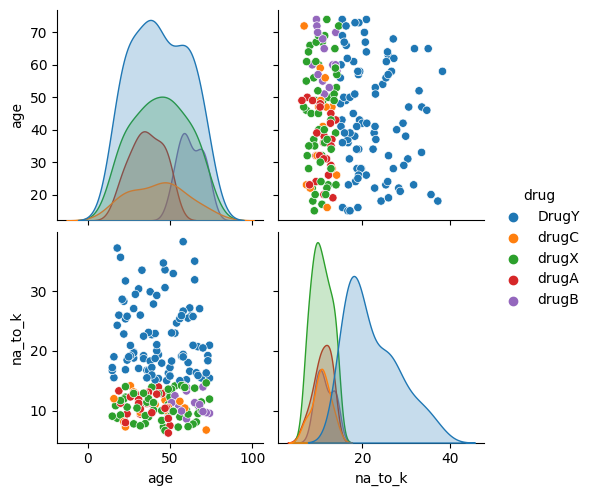

In [20]:
# analisando correlações
sns.pairplot(data, hue='drug')
plt.show()

- Na/K parece ser determinante no uso do medicamento Y.
- idade parece não ter influência.
- hipótese da correlação idade x Na/K não verificada. Provavelmente, é devido à baixa exploração da região de altos Na/K

In [22]:
# "correlação" entre sexo e remédios
print(pd.crosstab(data['sex'], data['drug']))

drug  DrugY  drugA  drugB  drugC  drugX
sex                                    
F        47      9      6      7     27
M        44     14     10      9     27


- aparentemente, o sexo não influencia no uso do medicamento Y. Confirmar com teste do $\chi^2$

In [23]:
# "correlação" entre bp e remédios
print(pd.crosstab(data['bp'], data['drug']))

drug    DrugY  drugA  drugB  drugC  drugX
bp                                       
HIGH       38     23     16      0      0
LOW        30      0      0     16     18
NORMAL     23      0      0      0     36


- aparentemente, o medicamento Y não é para pressão, ao contrário do A, B e do C

In [24]:
# "correlação" entre cholesterol e remédios
print(pd.crosstab(data['cholesterol'], data['drug']))

drug         DrugY  drugA  drugB  drugC  drugX
cholesterol                                   
HIGH            47     12      8     16     20
NORMAL          44     11      8      0     34


- aparentemente o medicamento Y não é para colesterol alto, ao contrário do C

### **Modelagem**

- vamos testar os seguintes modelos
  - Regressão Logística Regularizada
  - Árvores de Decisão
  - SVM

In [25]:
# transformar nosso alvo para o modelo One-vs-All
data['drug'] = data['drug'].apply(lambda x: 1 if x=='DrugY' else 0)
data.head()

,age,sex,bp,cholesterol,na_to_k,drug
0,23,F,HIGH,HIGH,25.355,1
1,47,M,LOW,HIGH,13.093,0
2,47,M,LOW,HIGH,10.114,0
3,28,F,NORMAL,HIGH,7.798,0
4,61,F,LOW,HIGH,18.043,1


- precisamos codificar as variáveis categóricas para Regressão Logística e SVM

In [28]:
# separando x e y
x = data.drop(['drug'], axis=1)
y = data[['drug']]

# separação treino e teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=2)

In [29]:
# criando um transformador de colunas categóricas
cat_transform = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='first'), ['sex', 'bp', 'cholesterol'])
], remainder='passthrough')

# criar pipelines de modelagem
logreg = Pipeline([
    ('cat_tranf', cat_transform),
    ('scaler', MinMaxScaler()),
    ('model', LogisticRegression(solver='saga'))
])
dt = Pipeline([
    ('cat_tranf', cat_transform),
    ('scaler', MinMaxScaler()),
    ('model', DecisionTreeClassifier(random_state=2))
])
svm = Pipeline([
    ('cat_tranf', cat_transform),
    ('scaler', MinMaxScaler()),
    ('model', SVC(random_state=2))
])

In [30]:
# configurando um amostrador de k folhas
splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)

In [42]:
# configurar os parâmetros de busca
params_svc = {
    'model__kernel': ['rbf', 'sigmoid', 'cosine', 'linear'],
    'model__C': np.random.uniform(0.01, 10, 100),
    'model__gamma': np.random.uniform(0.01, 10, 100),
}
params_logreg = {
    'model__penalty': ['l1', 'l2', None],
    'model__C': np.random.uniform(0.01, 10, 100),
}
params_dt = {
    'model__criterion': ['gini', 'entropy'],
    'model__max_depth': range(2, 11)
}

In [43]:
# configurando um buscador de hiperparâmetros
random_search_svc = RandomizedSearchCV(
    estimator=svm,
    param_distributions=params_svc,
    n_iter=50,
    scoring='f1_weighted',
    cv=splitter,
    refit=True,
    error_score=0
)
random_search_dt = RandomizedSearchCV(
    estimator=dt,
    param_distributions=params_dt,
    n_iter=50,
    scoring='f1_weighted',
    cv=splitter,
    refit=True,
    error_score=0
)
random_search_logreg = RandomizedSearchCV(
    estimator=logreg,
    param_distributions=params_logreg,
    n_iter=50,
    scoring='f1_weighted',
    cv=splitter,
    refit=True,
    error_score=0
)

In [46]:
# ajustar o modelo de regressão logística
random_search_logreg.fit(x_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=2, shuffle=True),
                   error_score=0,
                   estimator=Pipeline(steps=[('cat_tranf',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               OneHotEncoder(drop='first'),
                                                                               ['sex',
                                                                                'bp',
                                                                                'cholesterol'])])),
                                             ('scaler', MinMaxScaler()),
                                             ('model',
                                              LogisticRegression(solver='saga'))]),
                   n_iter=50,
                   param_distribut...
       5.08863973, 3.96854128, 7.96870187, 0.20547785, 3.65746088,
       7.70754936, 8.73010994, 0.49751837, 1.69105987, 9.61094929,
       1.88632838, 3.1271671 , 4.750847  , 9.16088091, 4.42504785,
       9.41173979, 5.68750316, 8.53842165, 3.25200642, 1.70641439,
       5.05772971, 7.43444533, 1.68373741, 8.64018078, 5.21939989,
       3.88213119, 7.03851972, 8.65128352, 7.36098501, 8.81496327]),
                                        'model__penalty': ['l1', 'l2', None]},
                   scoring='f1_weighted')

In [47]:
# ajustar o modelo de árvore de decisão
random_search_dt.fit(x_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=2, shuffle=True),
                   error_score=0,
                   estimator=Pipeline(steps=[('cat_tranf',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               OneHotEncoder(drop='first'),
                                                                               ['sex',
                                                                                'bp',
                                                                                'cholesterol'])])),
                                             ('scaler', MinMaxScaler()),
                                             ('model',
                                              DecisionTreeClassifier(random_state=2))]),
                   n_iter=50,
                   param_distributions={'model__criterion': ['gini', 'entropy'],
                                        'model__max_depth': range(2, 11)},
                   scoring='f1_weighted')

In [44]:
# ajustar o modelo de SVM
random_search_svc.fit(x_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=2, shuffle=True),
                   error_score=0,
                   estimator=Pipeline(steps=[('cat_tranf',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               OneHotEncoder(drop='first'),
                                                                               ['sex',
                                                                                'bp',
                                                                                'cholesterol'])])),
                                             ('scaler', MinMaxScaler()),
                                             ('model', SVC(random_state=2))]),
                   n_iter=50,
                   param_distributions={'model__...
       4.99120803, 6.81685224, 0.23200548, 6.75977049, 4.98316488,
       9.45424034, 1.50345571, 4.18204351, 9.65859721, 2.57567592,
       5.37407991, 5.57958126, 6.11112378, 8.32115363, 9.56430168,
       3.32267135, 4.79991479, 1.39399102, 2.17940991, 7.18491088,
       2.80826182, 4.11655628, 6.70901798, 0.81741102, 7.30964795]),
                                        'model__kernel': ['rbf', 'sigmoid',
                                                          'cosine', 'linear']},
                   scoring='f1_weighted')

In [48]:
# observando melhores parâmetros
print('Regressão Logística:', random_search_logreg.best_params_)
print('Árvore de Decisão:', random_search_dt.best_params_)
print('SVM:', random_search_svc.best_params_)

Regressão Logística: {'model__penalty': 'l1', 'model__C': 3.0057217841353467}
Árvore de Decisão: {'model__max_depth': 2, 'model__criterion': 'gini'}
SVM: {'model__kernel': 'linear', 'model__gamma': 8.365024894667977, 'model__C': 5.247901739833454}


In [49]:
# observando melhores desempenhos médios
print('Regressão Logística:', random_search_logreg.best_score_)
print('Árvore de Decisão:', random_search_dt.best_score_)
print('SVM:', random_search_svc.best_score_)

Regressão Logística: 0.9811195123695124
Árvore de Decisão: 0.993756109481916
SVM: 0.9812063552942307


In [50]:
# analisando o desempenho final - Regressão Logística
# realizando novas previsões
yhat_train = random_search_logreg.best_estimator_.predict(x_train)
yhat_test = random_search_logreg.best_estimator_.predict(x_test)

# análise do desempenho
print('Desempenho - Base de Treino - Regressão Logística')
print(classification_report(y_train, yhat_train))

print('Desempenho - Base de Teste - Regressão Logística')
print(classification_report(y_test, yhat_test))

Desempenho - Base de Treino - Regressão Logística
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        87
           1       1.00      0.99      0.99        73

    accuracy                           0.99       160
   macro avg       0.99      0.99      0.99       160
weighted avg       0.99      0.99      0.99       160

Desempenho - Base de Teste - Regressão Logística
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00        18

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



In [51]:
# analisando o desempenho final - Árvore de Decisão
# realizando novas previsões
yhat_train = random_search_dt.best_estimator_.predict(x_train)
yhat_test = random_search_dt.best_estimator_.predict(x_test)

# análise do desempenho
print('Desempenho - Base de Treino - Árvore de Decisão')
print(classification_report(y_train, yhat_train))

print('Desempenho - Base de Teste - Árvore de Decisão')
print(classification_report(y_test, yhat_test))

Desempenho - Base de Treino - Árvore de Decisão
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        87
           1       1.00      1.00      1.00        73

    accuracy                           1.00       160
   macro avg       1.00      1.00      1.00       160
weighted avg       1.00      1.00      1.00       160

Desempenho - Base de Teste - Árvore de Decisão
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00        18

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



In [52]:
# analisando o desempenho final - SVM
# realizando novas previsões
yhat_train = random_search_svc.best_estimator_.predict(x_train)
yhat_test = random_search_svc.best_estimator_.predict(x_test)

# análise do desempenho
print('Desempenho - Base de Treino - SVM')
print(classification_report(y_train, yhat_train))

print('Desempenho - Base de Teste - SVM')
print(classification_report(y_test, yhat_test))

Desempenho - Base de Treino - SVM
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        87
           1       0.99      0.96      0.97        73

    accuracy                           0.97       160
   macro avg       0.98      0.97      0.97       160
weighted avg       0.98      0.97      0.97       160

Desempenho - Base de Teste - SVM
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        22
           1       1.00      0.94      0.97        18

    accuracy                           0.97        40
   macro avg       0.98      0.97      0.97        40
weighted avg       0.98      0.97      0.97        40



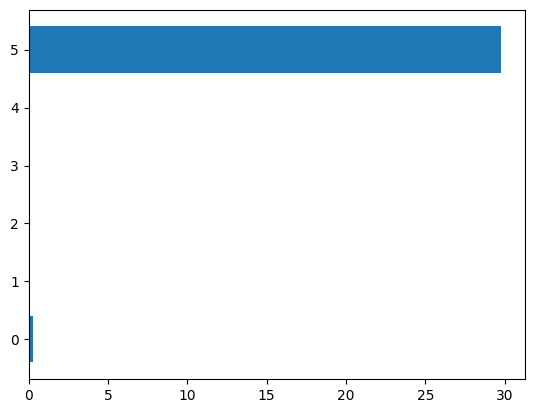

In [55]:
# criando conjunto de dados de importâncias de atributos
imp = random_search_logreg.best_estimator_['model'].coef_[0]

# construindo gráfico
plt.barh(y=range(6), width=imp)
plt.show()